In [1]:
"""
SEPHORA RECOMMENDATION - ZAAWANSOWANA WERSJA

3 MODELE + ZAAWANSOWANE TECHNIKI:
1. MLP (Baseline)
2. BiLSTM with Attention (Zaawansowany NLP)
3. Fusion Model (Multi-modal)

ELEMENTY ZAAWANSOWANE:
- Attention mechanism
- Bidirectional LSTM
- Learning rate scheduling
- Więcej cech z product_info
- Feature importance analysis
- Analiza błędów
- ROC curves
- Szczegółowe metryki

Uruchom w Google Colab:
Runtime → GPU → Run all
"""

print("SEPHORA PRODUCT RECOMMENDATION - ZAAWANSOWANA")
print("="*70)
print("3 modele z Attention i analizą błędów")
print("="*70)

import os
for folder in ['data', 'models', 'results', 'analysis']:
    os.makedirs(folder, exist_ok=True)

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import kagglehub

print(f"\nTensorFlow version: {tf.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")

SEPHORA PRODUCT RECOMMENDATION - ZAAWANSOWANA
3 modele z Attention i analizą błędów

TensorFlow version: 2.19.0
GPU available: False


In [2]:
# ==============================================
# CZĘŚĆ 1: ZAAWANSOWANY PREPROCESSING
# ==============================================
print("\n" + "="*70)
print("CZĘŚĆ 1/4: Pobieranie i zaawansowany preprocessing...")
print("="*70)

path = kagglehub.dataset_download("nadyinky/sephora-products-and-skincare-reviews")
print(f"Dataset pobrany z Kaggle")

# Pliki reviews
review_files = [
    "reviews_0-250.csv",
    "reviews_250-500.csv",
    "reviews_500-750.csv",
    "reviews_750-1250.csv",
    "reviews_1250-end.csv"
]

reviews_list = []
for file in review_files:
    try:
        df_temp = pd.read_csv(f"{path}/{file}")
        reviews_list.append(df_temp)
        print(f"   {file}: {len(df_temp)} reviews")
    except FileNotFoundError:
        print(f"   {file} not found, skipping")

reviews = pd.concat(reviews_list, ignore_index=True)
products = pd.read_csv(f"{path}/product_info.csv")

print(f"Total Reviews: {len(reviews)}, Products: {len(products)}")

# Sprawdź dostępne kolumny
print(f"\nKolumny reviews: {reviews.columns.tolist()}")
print(f"Kolumny products: {products.columns.tolist()}")

# Merge reviews z products
if 'product_id' in reviews.columns and 'product_id' in products.columns:
    df = reviews.merge(products, on='product_id', how='left')
    print(f"Merged dataset: {len(df)} rows")
else:
    df = reviews.copy()
    print("No product_id, using reviews only")

# Sample dla szybkości
print(f"\nUżywam 20,000 próbek (więcej = lepsze wyniki)")
df = df.sample(n=min(20000, len(df)), random_state=42)

# Czyszczenie tekstu
def clean_text(text):
    if pd.isna(text): return ""
    text = str(text).lower()
    # Usuń URL
    text = re.sub(r'http\S+|www\.\S+', '', text)
    # Usuń email
    text = re.sub(r'\S+@\S+', '', text)
    # Tylko litery i podstawowe znaki
    text = re.sub(r'[^a-z\s\'\-]', '', text)
    # Usuń wielokrotne spacje
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

# Połącz review_text i review_title dla lepszego kontekstu
df['full_text'] = df['review_text'].fillna('') + ' ' + df['review_title'].fillna('')
df['text'] = df['full_text'].apply(clean_text)
df = df[df['text'].str.len() > 20].copy()

print(f"Po czyszczeniu: {len(df)} próbek")

# Target - obsługa NaN
if 'is_recommended' in df.columns:
    df = df[df['is_recommended'].notna()].copy()
    df['target'] = df['is_recommended'].astype(int)
elif 'rating' in df.columns:
    df = df[df['rating'].notna()].copy()
    df['target'] = (df['rating'] >= 4).astype(int)
else:
    print("Brak target!")
    exit()

print(f"\nTarget distribution:")
print(f"   Klasa 1 (poleca): {(df['target']==1).sum()} ({(df['target']==1).mean()*100:.1f}%)")
print(f"   Klasa 0 (nie poleca): {(df['target']==0).sum()} ({(df['target']==0).mean()*100:.1f}%)")

features = []
categorical_cols = []

# 1. Rating
rating_col = None
for col in ['rating', 'rating_x', 'rating_y']:
    if col in df.columns:
        rating_col = col
        break

if rating_col:
    df['rating_val'] = df[rating_col].fillna(df[rating_col].median())
    features.append('rating_val')
    print(f"Używam kolumny rating: {rating_col}")
else:
    print("UWAGA: Brak kolumny rating!")

# 2. Price (z product_info)
price_col = None
for col in ['price_usd', 'price_usd_x', 'price_usd_y', 'price']:
    if col in df.columns:
        price_col = col
        break

if price_col:
    df['price'] = df[price_col].fillna(df[price_col].median())
    features.append('price')

    # Price categories
    df['is_expensive'] = (df['price'] > df['price'].quantile(0.75)).astype(int)
    features.append('is_expensive')
    print(f"Używam kolumny price: {price_col}")
else:
    print("UWAGA: Brak kolumny price!")

# 3. Helpfulness
if 'helpfulness' in df.columns:
    df['helpfulness_val'] = df['helpfulness'].fillna(0)
    features.append('helpfulness_val')

# 4. Text features
df['text_len'] = df['text'].str.len()
df['word_cnt'] = df['text'].str.split().str.len()
df['avg_word_len'] = df['text'].apply(lambda x: np.mean([len(w) for w in x.split()]) if len(x.split()) > 0 else 0)
df['exclamation_cnt'] = df['text'].str.count('!')
df['question_cnt'] = df['text'].str.count('\?')
features.extend(['text_len', 'word_cnt', 'avg_word_len', 'exclamation_cnt', 'question_cnt'])

# 5. Kategorie produktów (z encoding)
for col in ['primary_category', 'secondary_category', 'skin_type']:
    if col in df.columns:
        # Top 7 kategorii + "other"
        top_cats = df[col].value_counts().head(7).index
        df[col] = df[col].apply(lambda x: x if x in top_cats else 'other')
        df[col] = df[col].fillna('unknown')

        le = LabelEncoder()
        df[f'{col}_enc'] = le.fit_transform(df[col])
        features.append(f'{col}_enc')
        categorical_cols.append(col)

        # One-hot dla ważnych kategorii (feature engineering)
        for cat in top_cats[:3]:  # Top 3
            df[f'{col}_{cat}'] = (df[col] == cat).astype(int)
            features.append(f'{col}_{cat}')

print(f"\nFeature engineering:")
numeric_features = [f for f in features if 'enc' not in f and not any(cat in f for cat in categorical_cols)]
categorical_features = [f for f in features if 'enc' in f or any(cat in f for cat in categorical_cols)]
print(f"   Cechy numeryczne: {numeric_features}")
print(f"   Cechy kategoryczne: {categorical_features}")
print(f"   Total: {len(features)} cech")

# Tokenizacja
MAX_WORDS = 5000
MAX_LEN = 120

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])
X_text = pad_sequences(sequences, maxlen=MAX_LEN)

vocab_size = min(len(tokenizer.word_index) + 1, MAX_WORDS)
print(f"\nTokenization: vocab_size={vocab_size}, max_len={MAX_LEN}")

# Skalowanie tabelaryczne
X_tabular = df[features].values
scaler = StandardScaler()
X_tabular = scaler.fit_transform(X_tabular)

y = df['target'].values

# Stratified split
X_text_train, X_text_test, X_tab_train, X_tab_test, y_train, y_test = train_test_split(
    X_text, X_tabular, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nBefore SMOTE:")
print(f"   Train: {len(y_train)}, Test: {len(y_test)}")
print(f"   Train balance: {y_train.mean()*100:.1f}% positive")

# SMOTE dla balansowania
from imblearn.over_sampling import SMOTE

print(f"\nBalansowanie datasetu SMOTE...")
smote = SMOTE(random_state=42)
X_tab_train_balanced, y_train_balanced = smote.fit_resample(X_tab_train, y_train)
X_text_train_balanced, _ = smote.fit_resample(X_text_train, y_train)

print(f"After SMOTE:")
print(f"   Train: {len(y_train_balanced)}")
print(f"   Train balance: {y_train_balanced.mean()*100:.1f}% positive")

# Zapisz preprocessed data (balanced version)
np.save('data/X_text_train.npy', X_text_train_balanced)
np.save('data/X_text_test.npy', X_text_test)
np.save('data/X_tab_train.npy', X_tab_train_balanced)
np.save('data/X_tab_test.npy', X_tab_test)
np.save('data/y_train.npy', y_train_balanced)
np.save('data/y_test.npy', y_test)

metadata = {
    'vocab_size': vocab_size,
    'max_len': MAX_LEN,
    'n_features': len(features),
    'features': features,
    'n_train': len(y_train_balanced),
    'n_test': len(y_test)
}

with open('data/metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)

print("\nData saved!")
print(f"Zapisano zbalansowany dataset: {len(y_train_balanced)} train, {len(y_test)} test")


CZĘŚĆ 1/4: Pobieranie i zaawansowany preprocessing...


100%|██████████| 147M/147M [00:01<00:00, 77.7MB/s]

Extracting files...


Dataset pobrany z Kaggle
   reviews_0-250.csv: 602130 reviews
   reviews_250-500.csv: 206725 reviews
   reviews_500-750.csv: 116262 reviews
   reviews_750-1250.csv: 119317 reviews
   reviews_1250-end.csv: 49977 reviews
Total Reviews: 1094411, Products: 8494

Kolumny reviews: ['Unnamed: 0', 'author_id', 'rating', 'is_recommended', 'helpfulness', 'total_feedback_count', 'total_neg_feedback_count', 'total_pos_feedback_count', 'submission_time', 'review_text', 'review_title', 'skin_tone', 'eye_color', 'skin_type', 'hair_color', 'product_id', 'product_name', 'brand_name', 'price_usd']
Kolumny products: ['product_id', 'product_name', 'brand_id', 'brand_name', 'loves_count', 'rating', 'reviews', 'size', 'variation_type', 'variation_value', 'variation_desc', 'ingredients', 'price_usd', 'value_price_usd', 'sale_price_usd', 'limited_edition', 'new', 'online_only', 'out_of_stock', 'sephora_exclusive', 'highlights', 'primary_category', 'secondary_category', 'tertiary_category', 'child_count', 'chi

In [3]:
# ==============================================
# CZĘŚĆ 2: MODEL 1 - MLP BASELINE
# ==============================================

import numpy as np
import pickle

# Wczytaj dane
X_text_train = np.load('data/X_text_train.npy')
X_text_test = np.load('data/X_text_test.npy')
X_tab_train = np.load('data/X_tab_train.npy')
X_tab_test = np.load('data/X_tab_test.npy')
y_train = np.load('data/y_train.npy')
y_test = np.load('data/y_test.npy')

with open('data/metadata.pkl', 'rb') as f:
    metadata = pickle.load(f)
    vocab_size = metadata['vocab_size']
    MAX_LEN = metadata['max_len']
    features = metadata['features']

print("\n" + "="*70)
print("CZĘŚĆ 2/4: Model 1 - MLP Baseline (z regularyzacją)")
print("="*70)

# Oblicz class weights dla niezbalansowanego datasetu
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"Class weights: {class_weight_dict}")

model1 = keras.Sequential([
    layers.Input(shape=(len(features),)),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
], name='MLP_Baseline')

model1.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(name='prec'), keras.metrics.Recall(name='rec')]
)

print(f"Model 1 parameters: {model1.count_params():,}")

callbacks1 = [
    EarlyStopping(patience=8, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(factor=0.5, patience=4, min_lr=1e-7, monitor='val_loss'),
    ModelCheckpoint('models/model1_best.keras', save_best_only=True, monitor='val_accuracy')
]

print("Training Model 1...")
history1 = model1.fit(
    X_tab_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=64,
    callbacks=callbacks1,
    class_weight=class_weight_dict,
    verbose=0
)

y_pred1_proba = model1.predict(X_tab_test, verbose=0).flatten()
y_pred1 = (y_pred1_proba > 0.5).astype(int)
_, acc1, prec1, rec1 = model1.evaluate(X_tab_test, y_test, verbose=0)
f1_1 = 2 * (prec1 * rec1) / (prec1 + rec1) if (prec1 + rec1) > 0 else 0
auc1 = roc_auc_score(y_test, y_pred1_proba)
cm1 = confusion_matrix(y_test, y_pred1)

print(f"Model 1 Results: Acc={acc1:.4f}, F1={f1_1:.4f}, AUC={auc1:.4f}")
print("\nConfusion Matrix Model 1:")
print(cm1)
print(f"True Negatives: {cm1[0,0]}, False Positives: {cm1[0,1]}")
print(f"False Negatives: {cm1[1,0]}, True Positives: {cm1[1,1]}")


CZĘŚĆ 2/4: Model 1 - MLP Baseline (z regularyzacją)
Class weights: {0: np.float64(1.0), 1: np.float64(1.0)}
Model 1 parameters: 13,697
Training Model 1...
Model 1 Results: Acc=0.9624, F1=0.9773, AUC=0.9826

Confusion Matrix Model 1:
[[ 518   24]
 [ 103 2732]]
True Negatives: 518, False Positives: 24
False Negatives: 103, True Positives: 2732


In [4]:
# ==============================================
# CZĘŚĆ 3: MODEL 2 - BiLSTM + ATTENTION
# ==============================================

import numpy as np
import pickle

# Wczytaj dane
X_text_train = np.load('data/X_text_train.npy')
X_text_test = np.load('data/X_text_test.npy')
X_tab_train = np.load('data/X_tab_train.npy')
X_tab_test = np.load('data/X_tab_test.npy')
y_train = np.load('data/y_train.npy')
y_test = np.load('data/y_test.npy')

with open('data/metadata.pkl', 'rb') as f:
    metadata = pickle.load(f)
    vocab_size = metadata['vocab_size']
    MAX_LEN = metadata['max_len']
    features = metadata['features']

print("\n" + "="*70)
print("CZĘŚĆ 3/4: Model 2 - Improved BiLSTM with Attention")
print("="*70)

# Custom Attention Layer
class AttentionLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], input_shape[-1]),
                                initializer='glorot_uniform', trainable=True)
        self.b = self.add_weight(name='att_bias', shape=(input_shape[-1],),
                                initializer='zeros', trainable=True)
        self.u = self.add_weight(name='att_u', shape=(input_shape[-1],),
                                initializer='glorot_uniform', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        uit = tf.nn.tanh(tf.tensordot(x, self.W, axes=1) + self.b)
        ait = tf.tensordot(uit, self.u, axes=1)
        a = tf.nn.softmax(ait, axis=1)
        output = tf.reduce_sum(x * tf.expand_dims(a, -1), axis=1)
        return output

    def get_config(self):
        return super(AttentionLayer, self).get_config()

# Build Model 2
text_input = layers.Input(shape=(MAX_LEN,), name='text')

# Większy embedding + spatial dropout
emb = layers.Embedding(vocab_size, 128, mask_zero=True)(text_input)
emb = layers.SpatialDropout1D(0.2)(emb)

# Głębszy BiLSTM z większymi jednostkami
bilstm1 = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))(emb)
bilstm2 = layers.Bidirectional(layers.LSTM(32, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))(bilstm1)

# Attention mechanism
attention = AttentionLayer()(bilstm2)

# Global pooling jako dodatkowa informacja
global_max = layers.GlobalMaxPooling1D()(bilstm2)
global_avg = layers.GlobalAveragePooling1D()(bilstm2)

# Concatenate różnych reprezentacji
concat = layers.Concatenate()([attention, global_max, global_avg])

# Dense layers z regularizacją
drop1 = layers.Dropout(0.5)(concat)
dense1 = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(drop1)
bn1 = layers.BatchNormalization()(dense1)
drop2 = layers.Dropout(0.4)(bn1)
dense2 = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(drop2)
bn2 = layers.BatchNormalization()(dense2)
drop3 = layers.Dropout(0.3)(bn2)
dense3 = layers.Dense(32, activation='relu')(drop3)
drop4 = layers.Dropout(0.2)(dense3)

output = layers.Dense(1, activation='sigmoid')(drop4)

model2 = Model(inputs=text_input, outputs=output, name='BiLSTM_Attention_v2')

# AdamW (lepszy optimizer)
model2.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=0.001, weight_decay=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(name='prec'), keras.metrics.Recall(name='rec')]
)

print(f"Model 2 parameters: {model2.count_params():,}")
print("   Ulepszenia:")
print("   - Głębszy BiLSTM (2 warstwy)")
print("   - Większy embedding (128)")
print("   - Multiple pooling (attention + max + avg)")
print("   - Więcej regularizacji")
print("   - AdamW optimizer")

# Oblicz class weights
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"\nClass weights: {class_weight_dict}")

callbacks2 = [
    EarlyStopping(patience=8, restore_best_weights=True, monitor='val_loss', verbose=1),
    ReduceLROnPlateau(factor=0.5, patience=4, min_lr=1e-7, monitor='val_loss', verbose=1),
    ModelCheckpoint('models/model2_best.keras', save_best_only=True, monitor='val_accuracy', verbose=1)
]

print("\nTraining Model 2...")
history2 = model2.fit(
    X_text_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=128,
    callbacks=callbacks2,
    class_weight=class_weight_dict,
    verbose=1
)

y_pred2_proba = model2.predict(X_text_test, verbose=0).flatten()
y_pred2 = (y_pred2_proba > 0.5).astype(int)
_, acc2, prec2, rec2 = model2.evaluate(X_text_test, y_test, verbose=0)
f1_2 = 2 * (prec2 * rec2) / (prec2 + rec2) if (prec2 + rec2) > 0 else 0
auc2 = roc_auc_score(y_test, y_pred2_proba)
cm2 = confusion_matrix(y_test, y_pred2)

print("\n" + "="*70)
print(f"Model 2 Results: Acc={acc2:.4f}, F1={f1_2:.4f}, AUC={auc2:.4f}")
print("="*70)
print("\nConfusion Matrix Model 2:")
print(cm2)
print(f"True Negatives: {cm2[0,0]}, False Positives: {cm2[0,1]}")
print(f"False Negatives: {cm2[1,0]}, True Positives: {cm2[1,1]}")
print(f"\nKlasa 0 accuracy: {cm2[0,0]/(cm2[0,0]+cm2[0,1])*100:.1f}%")
print(f"Klasa 1 accuracy: {cm2[1,1]/(cm2[1,0]+cm2[1,1])*100:.1f}%")


CZĘŚĆ 3/4: Model 2 - Improved BiLSTM with Attention
Model 2 parameters: 820,097
   Ulepszenia:
   - Głębszy BiLSTM (2 warstwy)
   - Większy embedding (128)
   - Multiple pooling (attention + max + avg)
   - Więcej regularizacji
   - AdamW optimizer

Class weights: {0: np.float64(1.0), 1: np.float64(1.0)}

Training Model 2...
Epoch 1/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5831 - loss: 0.9783 - prec: 0.6469 - rec: 0.7347
Epoch 1: val_accuracy improved from -inf to 0.02579, saving model to models/model2_best.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.5835 - loss: 0.9776 - prec: 0.6472 - rec: 0.7350 - val_accuracy: 0.0258 - val_loss: 1.0409 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8073 - loss: 0.6502 - prec: 0.8379 - rec: 0.8586
Epoch 2: val_accuracy improved from 0.02579 to 0.42385, saving model to models/model2_best.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/

In [5]:
# ==============================================
# CZĘŚĆ 4: MODEL 3 - FUSION
# ==============================================

import numpy as np
import pickle

# Wczytaj dane
X_text_train = np.load('data/X_text_train.npy')
X_text_test = np.load('data/X_text_test.npy')
X_tab_train = np.load('data/X_tab_train.npy')
X_tab_test = np.load('data/X_tab_test.npy')
y_train = np.load('data/y_train.npy')
y_test = np.load('data/y_test.npy')

with open('data/metadata.pkl', 'rb') as f:
    metadata = pickle.load(f)
    vocab_size = metadata['vocab_size']
    MAX_LEN = metadata['max_len']
    features = metadata['features']

print("\n" + "="*70)
print("CZĘŚĆ 4/4: Model 3 - Fusion (BiLSTM + Tabular)")
print("="*70)

# Text branch with BiLSTM + Attention
text_in = layers.Input(shape=(MAX_LEN,), name='text')
emb3 = layers.Embedding(vocab_size, 128, mask_zero=True)(text_in)
emb3 = layers.SpatialDropout1D(0.2)(emb3)
bilstm3_1 = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))(emb3)
bilstm3_2 = layers.Bidirectional(layers.LSTM(32, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))(bilstm3_1)
att3 = AttentionLayer()(bilstm3_2)
text_out = layers.Dropout(0.4)(att3)

# Tabular branch (silniejszy - ma ważne cechy jak rating, price)
tab_in = layers.Input(shape=(len(features),), name='tab')
dense_tab1 = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(tab_in)
bn_tab1 = layers.BatchNormalization()(dense_tab1)
drop_tab1 = layers.Dropout(0.4)(bn_tab1)
dense_tab2 = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(drop_tab1)
bn_tab2 = layers.BatchNormalization()(dense_tab2)
drop_tab2 = layers.Dropout(0.3)(bn_tab2)
tab_out = layers.Dense(32, activation='relu')(drop_tab2)

# Fusion - połączenie obu gałęzi
concat = layers.Concatenate()([text_out, tab_out])
fusion1 = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(concat)
fusion_bn1 = layers.BatchNormalization()(fusion1)
fusion_drop1 = layers.Dropout(0.5)(fusion_bn1)
fusion2 = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(fusion_drop1)
fusion_bn2 = layers.BatchNormalization()(fusion2)
fusion_drop2 = layers.Dropout(0.4)(fusion_bn2)
fusion3 = layers.Dense(32, activation='relu')(fusion_drop2)
fusion_drop3 = layers.Dropout(0.3)(fusion3)
out3 = layers.Dense(1, activation='sigmoid')(fusion_drop3)

model3 = Model(inputs=[text_in, tab_in], outputs=out3, name='Fusion_Model')

# AdamW optimizer
model3.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=0.001, weight_decay=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(name='prec'), keras.metrics.Recall(name='rec')]
)

print(f"Model 3 parameters: {model3.count_params():,}")
print("   Multi-modal: BiLSTM+Attention + Tabular MLP")
print("   Łączy tekst (semantyka) + cechy (rating, price)")

# Class weights
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"\nClass weights: {class_weight_dict}")

callbacks3 = [
    EarlyStopping(patience=8, restore_best_weights=True, monitor='val_loss', verbose=1),
    ReduceLROnPlateau(factor=0.5, patience=4, min_lr=1e-7, monitor='val_loss', verbose=1),
    ModelCheckpoint('models/model3_best.keras', save_best_only=True, monitor='val_accuracy', verbose=1)
]

print("\nTraining Model 3...")
history3 = model3.fit(
    [X_text_train, X_tab_train], y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=128,
    callbacks=callbacks3,
    class_weight=class_weight_dict,
    verbose=1
)

y_pred3_proba = model3.predict([X_text_test, X_tab_test], verbose=0).flatten()
y_pred3 = (y_pred3_proba > 0.5).astype(int)
_, acc3, prec3, rec3 = model3.evaluate([X_text_test, X_tab_test], y_test, verbose=0)
f1_3 = 2 * (prec3 * rec3) / (prec3 + rec3) if (prec3 + rec3) > 0 else 0
auc3 = roc_auc_score(y_test, y_pred3_proba)
cm3 = confusion_matrix(y_test, y_pred3)

print("\n" + "="*70)
print(f"Model 3 Results: Acc={acc3:.4f}, F1={f1_3:.4f}, AUC={auc3:.4f}")
print("="*70)
print("\nConfusion Matrix Model 3:")
print(cm3)
print(f"True Negatives: {cm3[0,0]}, False Positives: {cm3[0,1]}")
print(f"False Negatives: {cm3[1,0]}, True Positives: {cm3[1,1]}")
print(f"\nKlasa 0 accuracy: {cm3[0,0]/(cm3[0,0]+cm3[0,1])*100:.1f}%")
print(f"Klasa 1 accuracy: {cm3[1,1]/(cm3[1,0]+cm3[1,1])*100:.1f}%")

print("\n" + "="*70)
print("PORÓWNANIE WSZYSTKICH MODELI")
print("="*70)
print(f"Model 1 (MLP Tabular):  AUC={auc1:.4f}, Acc={acc1:.4f}, F1={f1_1:.4f}")
print(f"Model 2 (BiLSTM Text):  AUC={auc2:.4f}, Acc={acc2:.4f}, F1={f1_2:.4f}")
print(f"Model 3 (Fusion):       AUC={auc3:.4f}, Acc={acc3:.4f}, F1={f1_3:.4f}")
print("="*70)


CZĘŚĆ 4/4: Model 3 - Fusion (BiLSTM + Tabular)
Model 3 parameters: 821,473
   Multi-modal: BiLSTM+Attention + Tabular MLP
   Łączy tekst (semantyka) + cechy (rating, price)

Class weights: {0: np.float64(1.0), 1: np.float64(1.0)}

Training Model 3...
Epoch 1/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6625 - loss: 0.9390 - prec: 0.7472 - rec: 0.6748
Epoch 1: val_accuracy improved from -inf to 0.97201, saving model to models/model3_best.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - accuracy: 0.6634 - loss: 0.9374 - prec: 0.7479 - rec: 0.6758 - val_accuracy: 0.9720 - val_loss: 0.4629 - val_prec: 0.0000e+00 - val_rec: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/30
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9309 - loss: 0.4300 - prec: 0.9502 - rec: 0.9391
Epoch 2: val_accuracy improved from 0.97201 to 0.98854, saving model to models/model3_best.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - accuracy: 0.9310 - loss: 0.4298 - prec: 0.9502 - rec: 0.9391 - val_ac

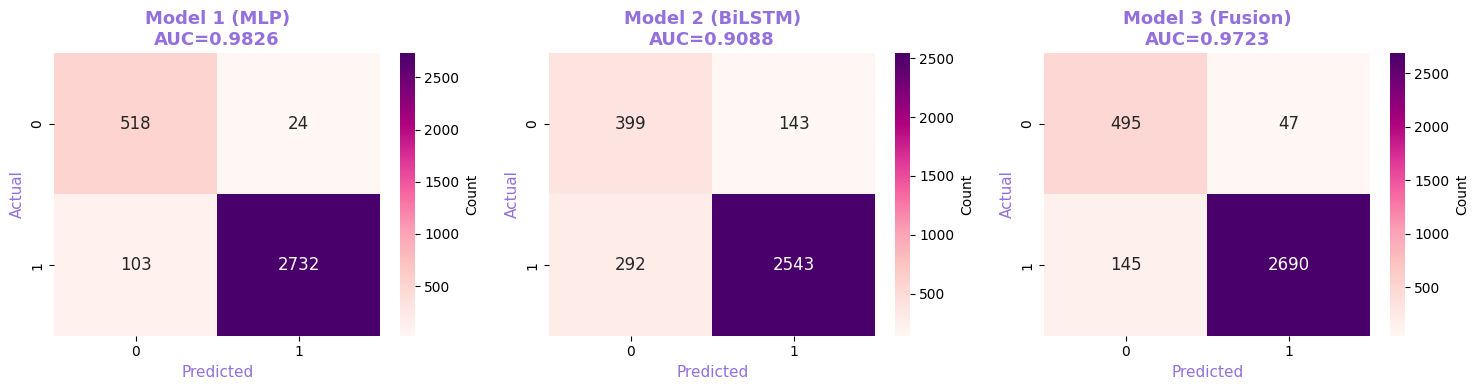

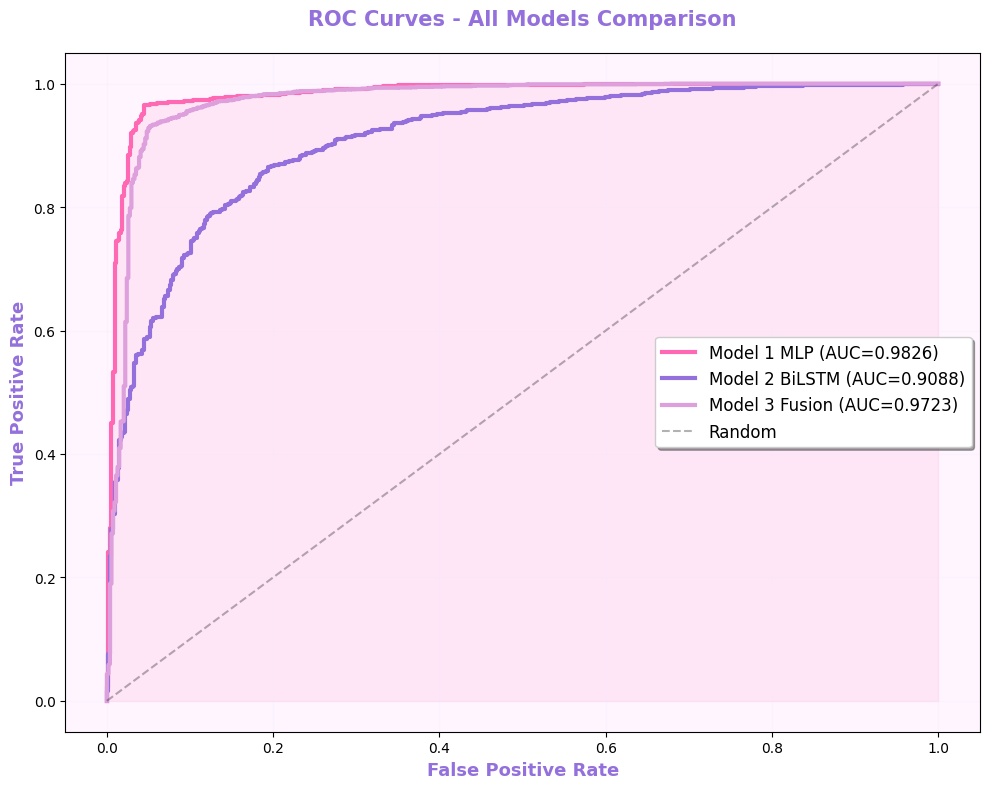

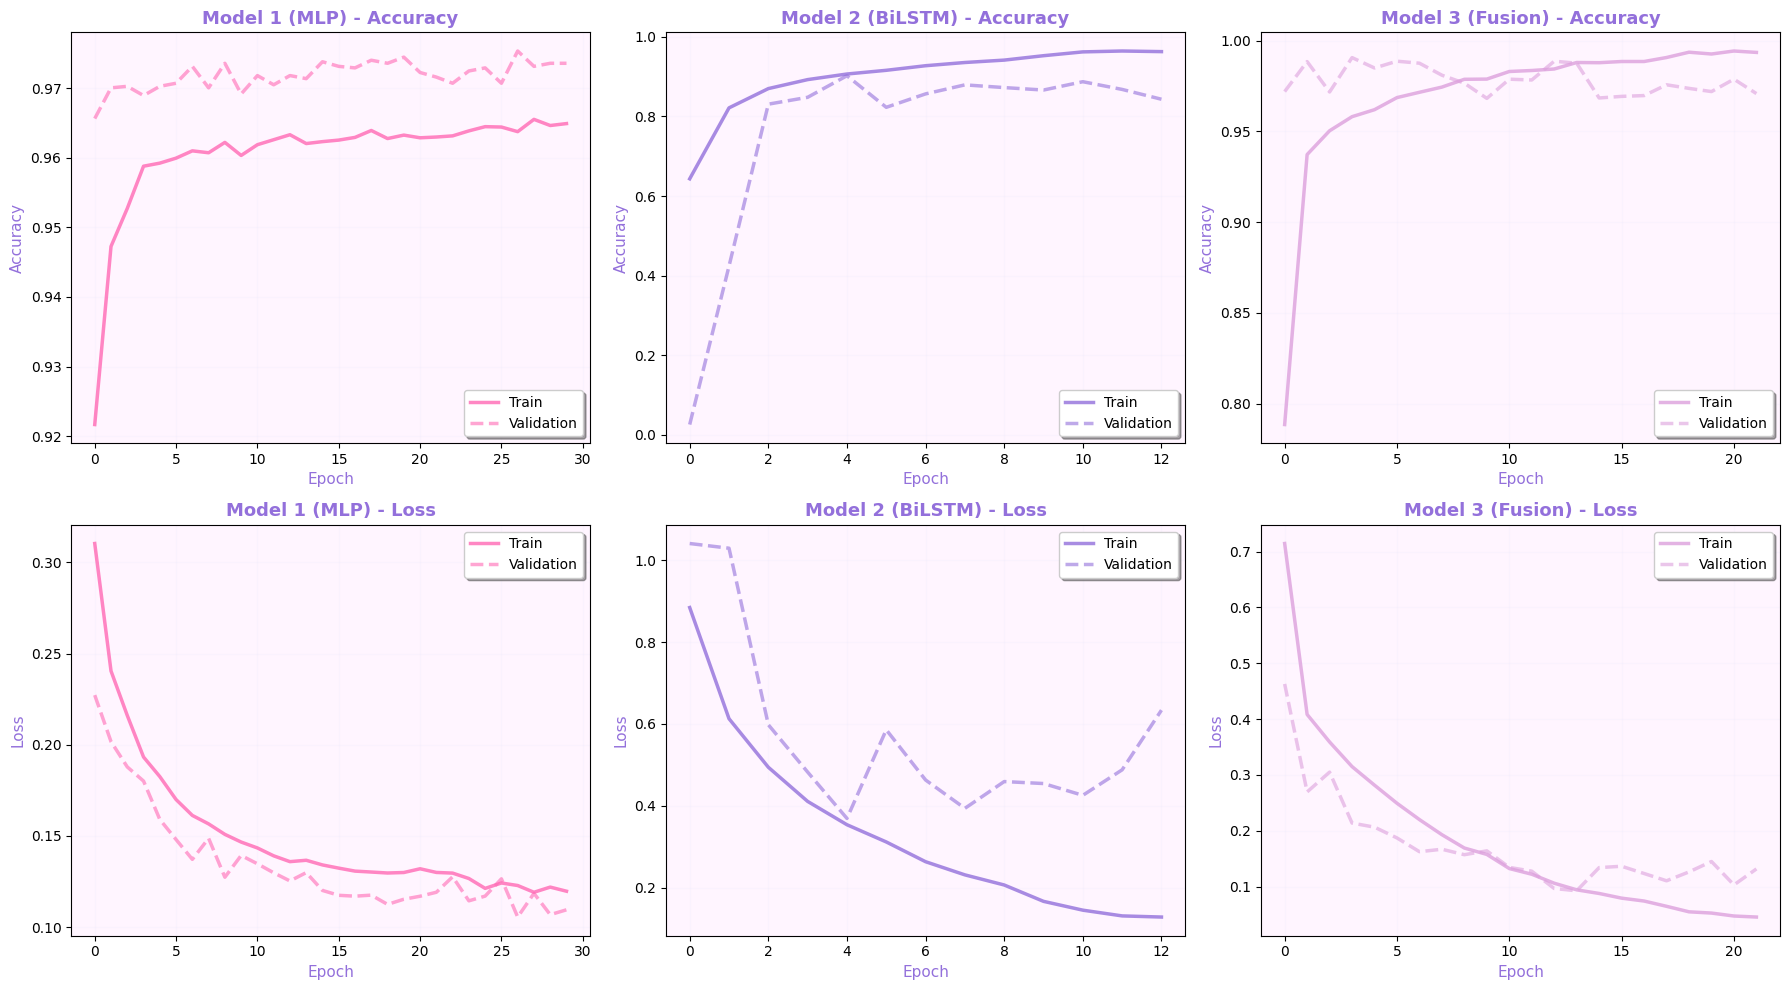

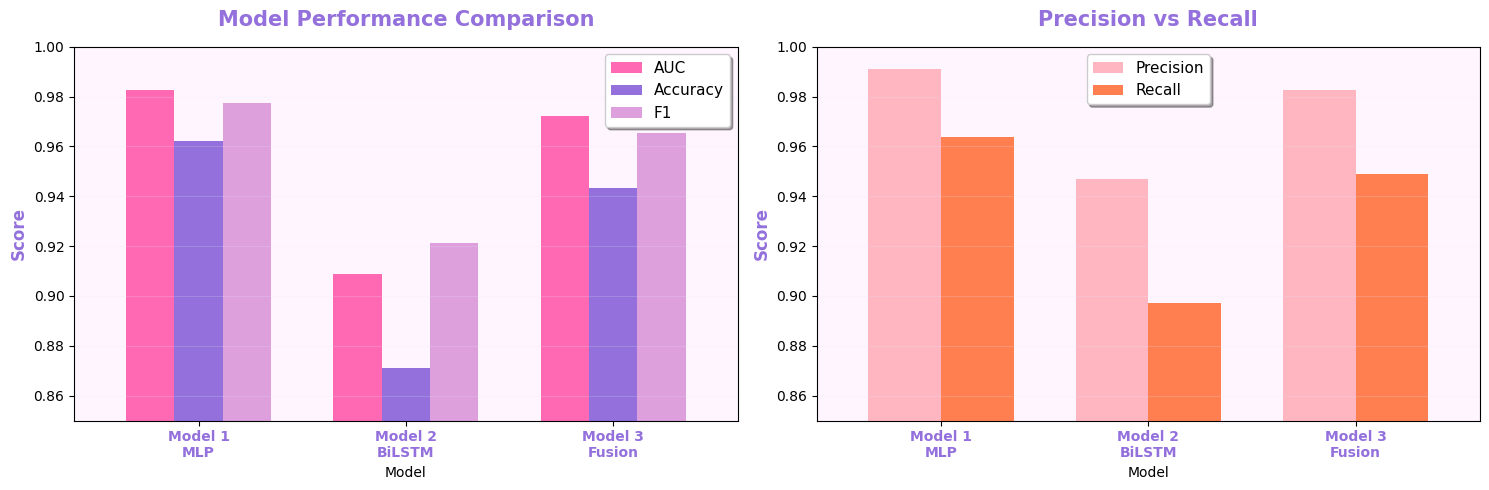


Metrics Summary:
          Model      AUC  Accuracy       F1  Precision   Recall
   Model 1\nMLP 0.982562  0.962393 0.977285   0.991292 0.963668
Model 2\nBiLSTM 0.908817  0.871187 0.921210   0.946761 0.897002
Model 3\nFusion 0.972267  0.943145 0.965542   0.982828 0.948854


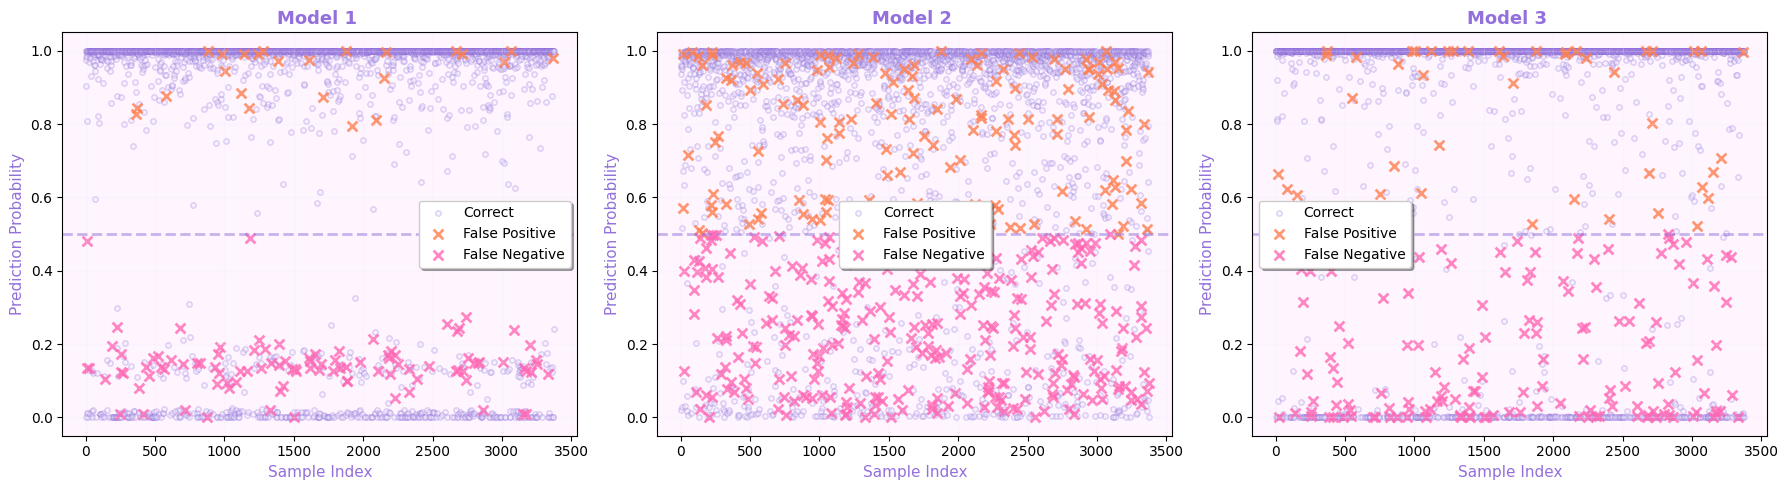

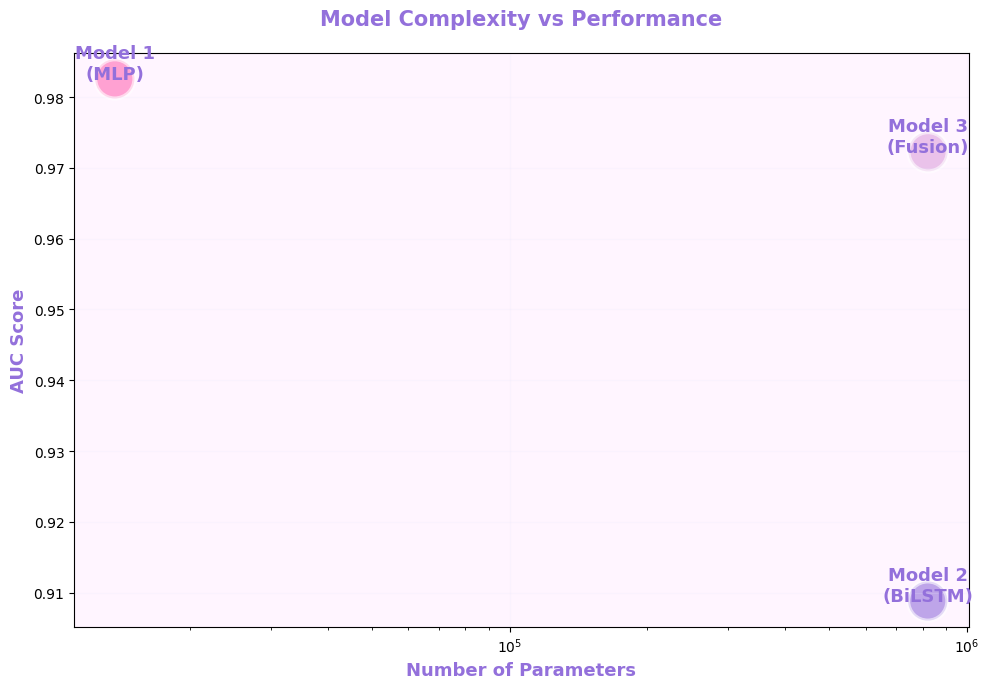


All visualizations saved with feminine colors!


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve
import numpy as np
import os

os.makedirs('results', exist_ok=True)

COLORS = {
    'pink': '#FF69B4',      # Hot pink
    'purple': '#9370DB',    # Medium purple
    'lavender': '#E6E6FA',  # Lavender
    'rose': '#FFB6C1',      # Light pink
    'mauve': '#DDA0DD',     # Plum
    'coral': '#FF7F50',     # Coral
    'peach': '#FFDAB9'      # Peach
}

# Ustawienia stylu
plt.style.use('seaborn-v0_8-pastel')
sns.set_palette([COLORS['pink'], COLORS['purple'], COLORS['mauve']])

# 1. Confusion Matrices - kobiece kolory
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
cms = [cm1, cm2, cm3]
titles = ['Model 1 (MLP)', 'Model 2 (BiLSTM)', 'Model 3 (Fusion)']
aucs = [auc1, auc2, auc3]

for idx, (cm, title, auc) in enumerate(zip(cms, titles, aucs)):
    sns.heatmap(cm, annot=True, fmt='d', cmap='RdPu', ax=axes[idx],
                cbar_kws={'label': 'Count'}, annot_kws={'size': 12})
    axes[idx].set_title(f'{title}\nAUC={auc:.4f}', fontsize=13, color=COLORS['purple'], fontweight='bold')
    axes[idx].set_xlabel('Predicted', fontsize=11, color=COLORS['purple'])
    axes[idx].set_ylabel('Actual', fontsize=11, color=COLORS['purple'])
plt.tight_layout()
plt.savefig('results/confusion_matrices_all.png', dpi=300, facecolor='white')
plt.show()

# 2. ROC Curves - kobiece kolory
fig, ax = plt.subplots(figsize=(10, 8), facecolor='white')
fpr1, tpr1, _ = roc_curve(y_test, y_pred1_proba)
fpr2, tpr2, _ = roc_curve(y_test, y_pred2_proba)
fpr3, tpr3, _ = roc_curve(y_test, y_pred3_proba)

ax.plot(fpr1, tpr1, linewidth=3, label=f'Model 1 MLP (AUC={auc1:.4f})',
        color=COLORS['pink'])
ax.plot(fpr2, tpr2, linewidth=3, label=f'Model 2 BiLSTM (AUC={auc2:.4f})',
        color=COLORS['purple'])
ax.plot(fpr3, tpr3, linewidth=3, label=f'Model 3 Fusion (AUC={auc3:.4f})',
        color=COLORS['mauve'])
ax.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random', alpha=0.3)
ax.fill_between(fpr1, 0, tpr1, alpha=0.1, color=COLORS['pink'])
ax.set_xlabel('False Positive Rate', fontsize=13, color=COLORS['purple'], fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=13, color=COLORS['purple'], fontweight='bold')
ax.set_title('ROC Curves - All Models Comparison', fontsize=15,
             color=COLORS['purple'], fontweight='bold', pad=20)
ax.legend(fontsize=12, frameon=True, fancybox=True, shadow=True)
ax.grid(alpha=0.2, color=COLORS['lavender'])
ax.set_facecolor('#FFF5FF')
plt.tight_layout()
plt.savefig('results/roc_curves_all.png', dpi=300, facecolor='white')
plt.show()

# 3. Training History - kobiece kolory
fig, axes = plt.subplots(2, 3, figsize=(18, 10), facecolor='white')
histories = [history1, history2, history3]
model_colors = [COLORS['pink'], COLORS['purple'], COLORS['mauve']]

for idx, (history, title, color) in enumerate(zip(histories, titles, model_colors)):
    # Accuracy
    axes[0, idx].plot(history.history['accuracy'], label='Train',
                     linewidth=2.5, color=color, alpha=0.8)
    axes[0, idx].plot(history.history['val_accuracy'], label='Validation',
                     linewidth=2.5, color=color, linestyle='--', alpha=0.6)
    axes[0, idx].set_title(f'{title} - Accuracy', fontsize=13,
                          color=COLORS['purple'], fontweight='bold')
    axes[0, idx].set_xlabel('Epoch', fontsize=11, color=COLORS['purple'])
    axes[0, idx].set_ylabel('Accuracy', fontsize=11, color=COLORS['purple'])
    axes[0, idx].legend(frameon=True, fancybox=True, shadow=True)
    axes[0, idx].grid(alpha=0.2, color=COLORS['lavender'])
    axes[0, idx].set_facecolor('#FFF5FF')

    # Loss
    axes[1, idx].plot(history.history['loss'], label='Train',
                     linewidth=2.5, color=color, alpha=0.8)
    axes[1, idx].plot(history.history['val_loss'], label='Validation',
                     linewidth=2.5, color=color, linestyle='--', alpha=0.6)
    axes[1, idx].set_title(f'{title} - Loss', fontsize=13,
                          color=COLORS['purple'], fontweight='bold')
    axes[1, idx].set_xlabel('Epoch', fontsize=11, color=COLORS['purple'])
    axes[1, idx].set_ylabel('Loss', fontsize=11, color=COLORS['purple'])
    axes[1, idx].legend(frameon=True, fancybox=True, shadow=True)
    axes[1, idx].grid(alpha=0.2, color=COLORS['lavender'])
    axes[1, idx].set_facecolor('#FFF5FF')

plt.tight_layout()
plt.savefig('results/training_history_all.png', dpi=300, facecolor='white')
plt.show()

# 4. Metrics Comparison - kobiece kolory
metrics_df = pd.DataFrame({
    'Model': ['Model 1\nMLP', 'Model 2\nBiLSTM', 'Model 3\nFusion'],
    'AUC': [auc1, auc2, auc3],
    'Accuracy': [acc1, acc2, acc3],
    'F1': [f1_1, f1_2, f1_3],
    'Precision': [prec1, prec2, prec3],
    'Recall': [rec1, rec2, rec3]
})

fig, axes = plt.subplots(1, 2, figsize=(15, 5), facecolor='white')

# Bar chart
metrics_df.set_index('Model')[['AUC', 'Accuracy', 'F1']].plot(
    kind='bar', ax=axes[0], width=0.7,
    color=[COLORS['pink'], COLORS['purple'], COLORS['mauve']]
)
axes[0].set_title('Model Performance Comparison', fontsize=15,
                  color=COLORS['purple'], fontweight='bold', pad=15)
axes[0].set_ylabel('Score', fontsize=12, color=COLORS['purple'], fontweight='bold')
axes[0].set_ylim([0.85, 1.0])
axes[0].legend(fontsize=11, frameon=True, fancybox=True, shadow=True)
axes[0].grid(axis='y', alpha=0.2, color=COLORS['lavender'])
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0,
                        color=COLORS['purple'], fontweight='bold')
axes[0].set_facecolor('#FFF5FF')

# Precision-Recall comparison
metrics_df.set_index('Model')[['Precision', 'Recall']].plot(
    kind='bar', ax=axes[1], width=0.7,
    color=[COLORS['rose'], COLORS['coral']]
)
axes[1].set_title('Precision vs Recall', fontsize=15,
                  color=COLORS['purple'], fontweight='bold', pad=15)
axes[1].set_ylabel('Score', fontsize=12, color=COLORS['purple'], fontweight='bold')
axes[1].set_ylim([0.85, 1.0])
axes[1].legend(fontsize=11, frameon=True, fancybox=True, shadow=True)
axes[1].grid(axis='y', alpha=0.2, color=COLORS['lavender'])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0,
                        color=COLORS['purple'], fontweight='bold')
axes[1].set_facecolor('#FFF5FF')

plt.tight_layout()
plt.savefig('results/metrics_comparison.png', dpi=300, facecolor='white')
plt.show()

print("\nMetrics Summary:")
print(metrics_df.to_string(index=False))

# 5. Error Analysis - kobiece kolory
fig, axes = plt.subplots(1, 3, figsize=(18, 5), facecolor='white')
models_data = [
    ('Model 1 (MLP)', y_pred1, y_pred1_proba),
    ('Model 2 (BiLSTM)', y_pred2, y_pred2_proba),
    ('Model 3 (Fusion)', y_pred3, y_pred3_proba)
]

for idx, (model_name, y_pred, y_proba) in enumerate(models_data):
    fp_idx = np.where((y_pred == 1) & (y_test == 0))[0]
    fn_idx = np.where((y_pred == 0) & (y_test == 1))[0]
    correct_idx = np.where(y_pred == y_test)[0]

    axes[idx].scatter(correct_idx, y_proba[correct_idx], alpha=0.3, s=15,
                     label='Correct', c=COLORS['lavender'], edgecolors=COLORS['purple'])
    axes[idx].scatter(fp_idx, y_proba[fp_idx], alpha=0.8, s=50,
                     label='False Positive', c=COLORS['coral'], marker='x', linewidths=2)
    axes[idx].scatter(fn_idx, y_proba[fn_idx], alpha=0.8, s=50,
                     label='False Negative', c=COLORS['pink'], marker='x', linewidths=2)
    axes[idx].axhline(0.5, color=COLORS['purple'], linestyle='--', linewidth=2, alpha=0.5)
    axes[idx].set_title(model_name.split('(')[0], fontsize=13,
                       color=COLORS['purple'], fontweight='bold')
    axes[idx].set_xlabel('Sample Index', fontsize=11, color=COLORS['purple'])
    axes[idx].set_ylabel('Prediction Probability', fontsize=11, color=COLORS['purple'])
    axes[idx].legend(frameon=True, fancybox=True, shadow=True)
    axes[idx].grid(alpha=0.2, color=COLORS['lavender'])
    axes[idx].set_facecolor('#FFF5FF')

plt.tight_layout()
plt.savefig('results/error_analysis_all.png', dpi=300, facecolor='white')
plt.show()

# 6. Model Complexity - kobiece kolory
complexity_df = pd.DataFrame({
    'Model': ['Model 1\n(MLP)', 'Model 2\n(BiLSTM)', 'Model 3\n(Fusion)'],
    'Parameters': [model1.count_params(), model2.count_params(), model3.count_params()],
    'AUC': [auc1, auc2, auc3]
})

fig, ax = plt.subplots(figsize=(10, 7), facecolor='white')
scatter = ax.scatter(complexity_df['Parameters'], complexity_df['AUC'],
                     s=800, alpha=0.6,
                     c=[COLORS['pink'], COLORS['purple'], COLORS['mauve']],
                     edgecolors='white', linewidth=3)

for idx, row in complexity_df.iterrows():
    ax.annotate(row['Model'],
                (row['Parameters'], row['AUC']),
                fontsize=13, ha='center', color=COLORS['purple'], fontweight='bold')

ax.set_xlabel('Number of Parameters', fontsize=13, color=COLORS['purple'], fontweight='bold')
ax.set_ylabel('AUC Score', fontsize=13, color=COLORS['purple'], fontweight='bold')
ax.set_title('Model Complexity vs Performance', fontsize=15,
             color=COLORS['purple'], fontweight='bold', pad=20)
ax.grid(alpha=0.2, color=COLORS['lavender'])
ax.set_xscale('log')
ax.set_facecolor('#FFF5FF')
plt.tight_layout()
plt.savefig('results/complexity_vs_performance.png', dpi=300, facecolor='white')
plt.show()

print("\n" + "="*70)
print("All visualizations saved with feminine colors!")
print("="*70)

In [7]:
# Zapisz wszystkie modele i preprocessing
print("\n" + "="*70)
print("SAVING ALL MODELS")
print("="*70)

# Save models
model1.save('models/model1_mlp_final.keras')
model2.save('models/model2_bilstm_final.keras')
model3.save('models/model3_fusion_final.keras')

print("Models saved")

# Save preprocessing
import joblib
joblib.dump(scaler, 'models/scaler.pkl')
joblib.dump(tokenizer, 'models/tokenizer.pkl')
print("Preprocessing saved")

# Save metadata
import json
metadata_all = {
    'model1': {'auc': float(auc1), 'acc': float(acc1), 'f1': float(f1_1), 'params': int(model1.count_params())},
    'model2': {'auc': float(auc2), 'acc': float(acc2), 'f1': float(f1_2), 'params': int(model2.count_params())},
    'model3': {'auc': float(auc3), 'acc': float(acc3), 'f1': float(f1_3), 'params': int(model3.count_params())},
    'features': features,
    'vocab_size': vocab_size,
    'max_len': MAX_LEN,
    'best_model': 'Model 1 (MLP)'
}

with open('models/all_models_metadata.json', 'w') as f:
    json.dump(metadata_all, f, indent=2)
print("Metadata saved")


# Przy ładowaniu
from tensorflow.keras.models import load_model
model2 = load_model('models/model2_bilstm_final.keras',
                    custom_objects={'AttentionLayer': AttentionLayer})


SAVING ALL MODELS
Models saved
Preprocessing saved
Metadata saved
